# Notebook 01: Exploration

Now that I have an EV, I want to know some basic information about it:

- How far can I drive with it?
- How does that change depending on terrain, accessory use, or other things?
- What would a cross-Canada trip look like?

To that end, I've been recording data (though not as assiduously as I might...):

- Odometer readings
- Battery percentage
- Estimated battery range
- Occasional details about destination, whether A/C was on, and the like

In this notebook, I begin to explore the data that's been recorded so far.

Let's start with the usual imports.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

In [2]:
!ls -l ../data/raw ../data/interim

../data/interim:
total 12
-rw-r--r--. 1 aardvark aardvark 8689 Nov  1 17:18 car_ev_stats-BatteryOdometerDistance_Sheet.csv

../data/raw:
total 28
-rw-r--r--. 1 aardvark aardvark 27154 Nov  1 14:32 car_ev_stats.ods


In [3]:
EV_CSV = "../data/interim/car_ev_stats-BatteryOdometerDistance_Sheet.csv"
df = pd.read_csv(EV_CSV, parse_dates=["Date"], index_col="Date")
df.drop(axis="columns", columns=["Charge?", "Charge time", "Charge cost", "Weather"], inplace=True)
df

Odometer (km)  Battery percentage  \
Date                                            
NaT                   NaN                 NaN   
2021-01-12           32.0                93.0   
2021-01-12           54.0                89.0   
2021-01-13           72.0                86.0   
2021-01-15           93.0                81.0   
...                   ...                 ...   
2021-10-29         5823.0                70.0   
2021-10-30         5851.0                64.0   
2021-10-31         5943.0                42.0   
2021-10-31         5943.0                51.0   
2021-10-31         6029.0                32.0   

            Estimated Distance Remaining (km)  \
Date                                            
NaT                                       NaN   
2021-01-12                              407.0   
2021-01-12                              391.0   
2021-01-13                              385.0   
2021-01-15                              365.0   
...                                       ...   
2021-10-29                              335.0   
2021-10-30                              284.0   
2021-10-31                              194.0   
2021-10-31                              237.0   
2021-10-31                              151.0   

                                                   Notes  
Date                                                      
NaT         Note: each line shows end of trip or charge.  
2021-01-12            Stats when picked up at dealership  
2021-01-12                                           NaN  
2021-01-13                    Surrey, doctor appointment  
2021-01-15                                           NaN  
...                                                  ...  
2021-10-29                                           NaN  
2021-10-30                                           NaN  
2021-10-31                           New West → Squamish  
2021-10-31                            Charge at Squamish  
2021-10-31                                           NaN  

[195 rows x 4 columns]

In [4]:
df.dtypes

Odometer (km)                        float64
Battery percentage                   float64
Estimated Distance Remaining (km)    float64
Notes                                 object
dtype: object

Let's get some plots:

Text(0.5, 1.0, 'Battery percentage')

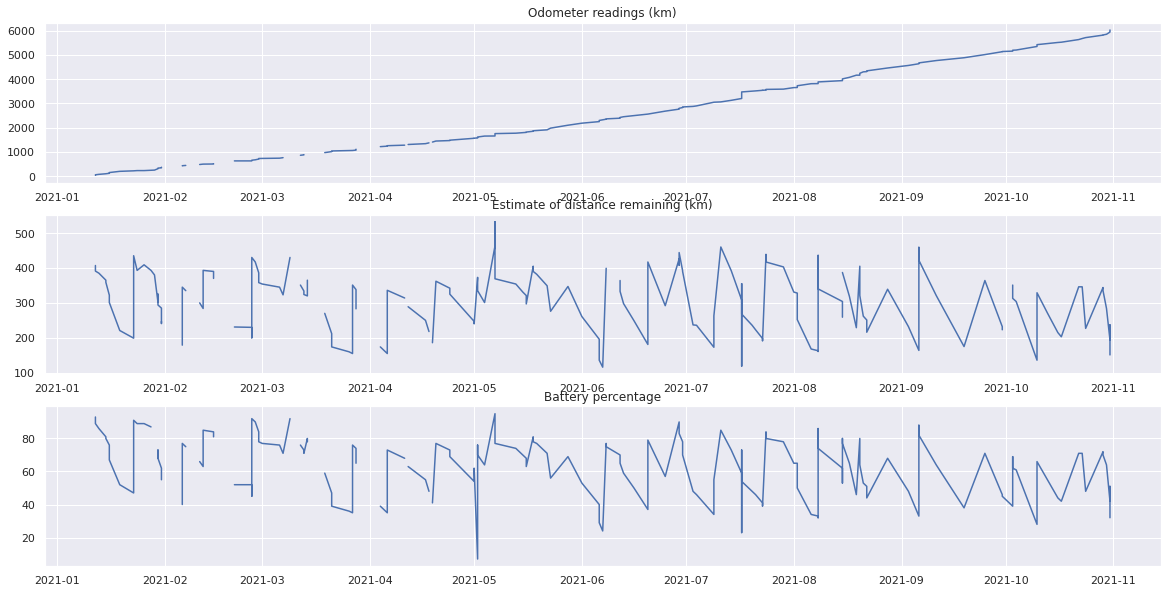

In [5]:
# https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html
plt.rcParams["figure.figsize"] = (20, 10)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.plot(df["Odometer (km)"])
ax1.set_title("Odometer readings (km)")
ax2.plot(df["Estimated Distance Remaining (km)"])
ax2.set_title("Estimate of distance remaining (km)")
ax3.plot(df["Battery percentage"])
ax3.set_title("Battery percentage")

Okay, interesting.

We can get the distance driven at each point by using the `diff()` method:

<AxesSubplot:xlabel='Date'>

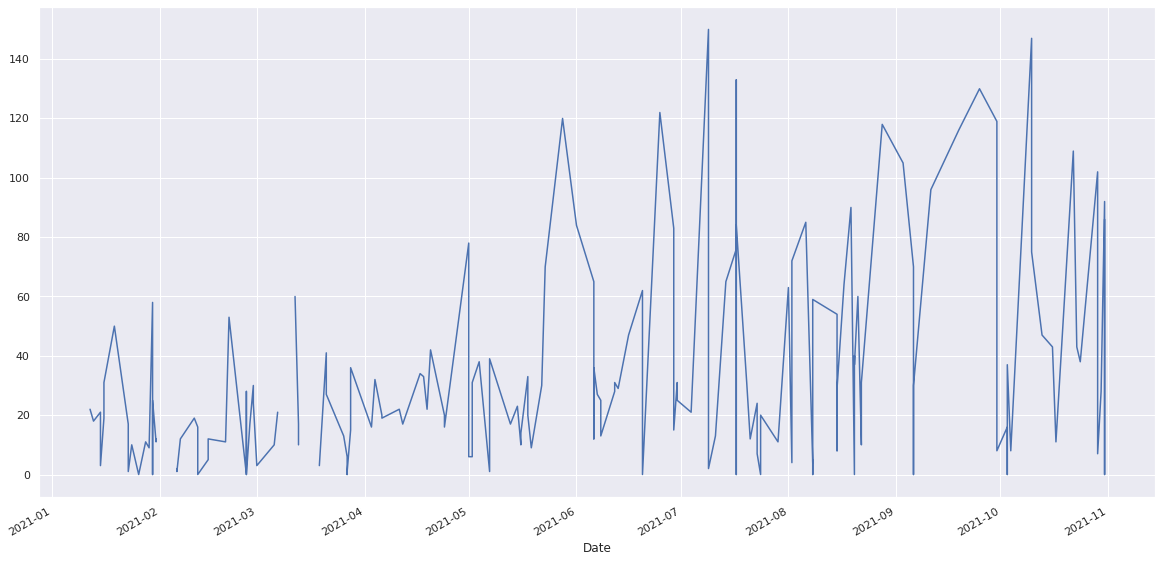

In [6]:
df["distance_driven_km"] = df["Odometer (km)"].diff()
df.distance_driven_km.plot()

...which in turn brings up an interesting question:  how accurate is the car's estimate of its range?

We should be able to get this by comparing the distance driven with the difference in range estimates.  For example:  On January 23rd, we drove 17 kilometres -- but the estimated range went down 22 kilometres.  That is, the car was over-optimistic.  This could be because of heating/cooling, accessory use, driving up lots of hills, inefficient stop-and-go driving, or lots of other things.

Let's start by getting that difference between range estimates; that'll go in a column named `distance_battery_thought_it_could_drive_km`.

<AxesSubplot:xlabel='Date'>

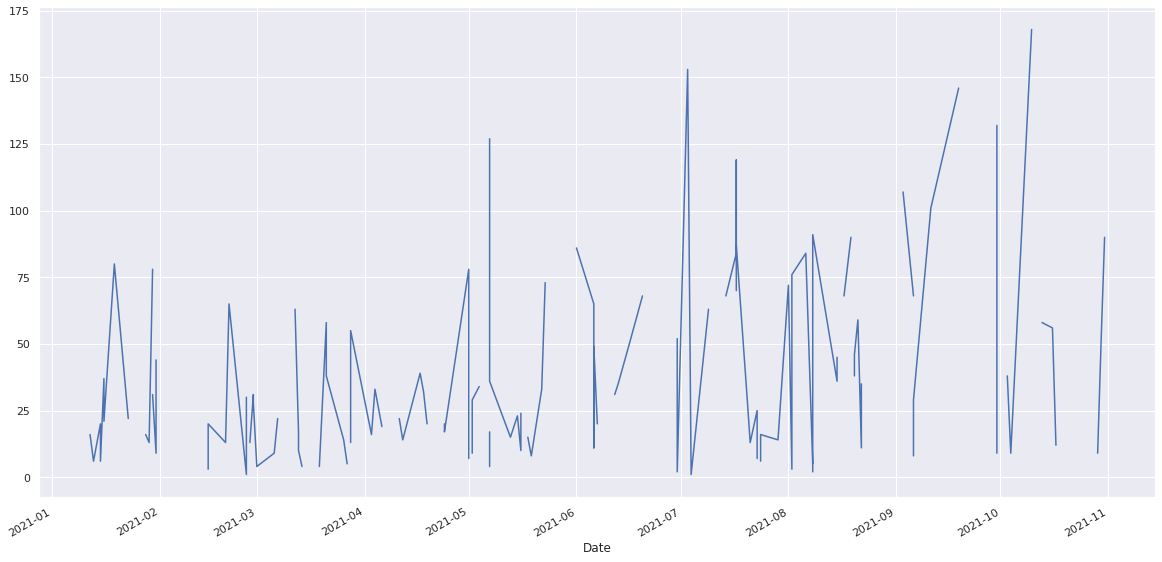

In [7]:
df["distance_battery_thought_it_could_drive_km"] = df["Estimated Distance Remaining (km)"].diff(periods=-1).shift(1)
# Ignore times when estimated range jumped up -- this is when the battery has been charged
df["distance_battery_thought_it_could_drive_km"] = df["distance_battery_thought_it_could_drive_km"].where(df["distance_battery_thought_it_could_drive_km"] > 0)
df["distance_battery_thought_it_could_drive_km"].plot()

Next we'll compute the difference between actual range and estimated range.  If that difference is *positive*, the car went *further* than it thought it would.  If the difference is *negative*, the car did *not* go as far is it thought it would.

In [8]:
df["actual_range_minus_expected_range"] = df["distance_driven_km"] - df["distance_battery_thought_it_could_drive_km"]
df.head(10)

Odometer (km)  Battery percentage  \
Date                                            
NaT                   NaN                 NaN   
2021-01-12           32.0                93.0   
2021-01-12           54.0                89.0   
2021-01-13           72.0                86.0   
2021-01-15           93.0                81.0   
2021-01-15           96.0                80.0   
2021-01-16          115.0                76.0   
2021-01-16          146.0                67.0   
2021-01-19          196.0                52.0   
2021-01-23          213.0                47.0   

            Estimated Distance Remaining (km)  \
Date                                            
NaT                                       NaN   
2021-01-12                              407.0   
2021-01-12                              391.0   
2021-01-13                              385.0   
2021-01-15                              365.0   
2021-01-15                              359.0   
2021-01-16                              322.0   
2021-01-16                              301.0   
2021-01-19                              221.0   
2021-01-23                              199.0   

                                                   Notes  distance_driven_km  \
Date                                                                           
NaT         Note: each line shows end of trip or charge.                 NaN   
2021-01-12            Stats when picked up at dealership                 NaN   
2021-01-12                                           NaN                22.0   
2021-01-13                    Surrey, doctor appointment                18.0   
2021-01-15                                           NaN                21.0   
2021-01-15                                           NaN                 3.0   
2021-01-16                                Long & McQuade                19.0   
2021-01-16     Xtofaros via Burnaby Mountain, Canada Way                31.0   
2021-01-19                 Downtown & back, 19km one way                50.0   
2021-01-23                         Foreshore Park & back                17.0   

            distance_battery_thought_it_could_drive_km  \
Date                                                     
NaT                                                NaN   
2021-01-12                                         NaN   
2021-01-12                                        16.0   
2021-01-13                                         6.0   
2021-01-15                                        20.0   
2021-01-15                                         6.0   
2021-01-16                                        37.0   
2021-01-16                                        21.0   
2021-01-19                                        80.0   
2021-01-23                                        22.0   

            actual_range_minus_expected_range  
Date                                           
NaT                                       NaN  
2021-01-12                                NaN  
2021-01-12                                6.0  
2021-01-13                               12.0  
2021-01-15                                1.0  
2021-01-15                               -3.0  
2021-01-16                              -18.0  
2021-01-16                               10.0  
2021-01-19                              -30.0  
2021-01-23                               -5.0

Let's plot by date.  Again, numbers over 0 are *good*: we're going further than the onboard estimate.  (Though arguably, it should hover around 0 -- we don't want to distrust the onboard estimate!)

<AxesSubplot:xlabel='Date'>

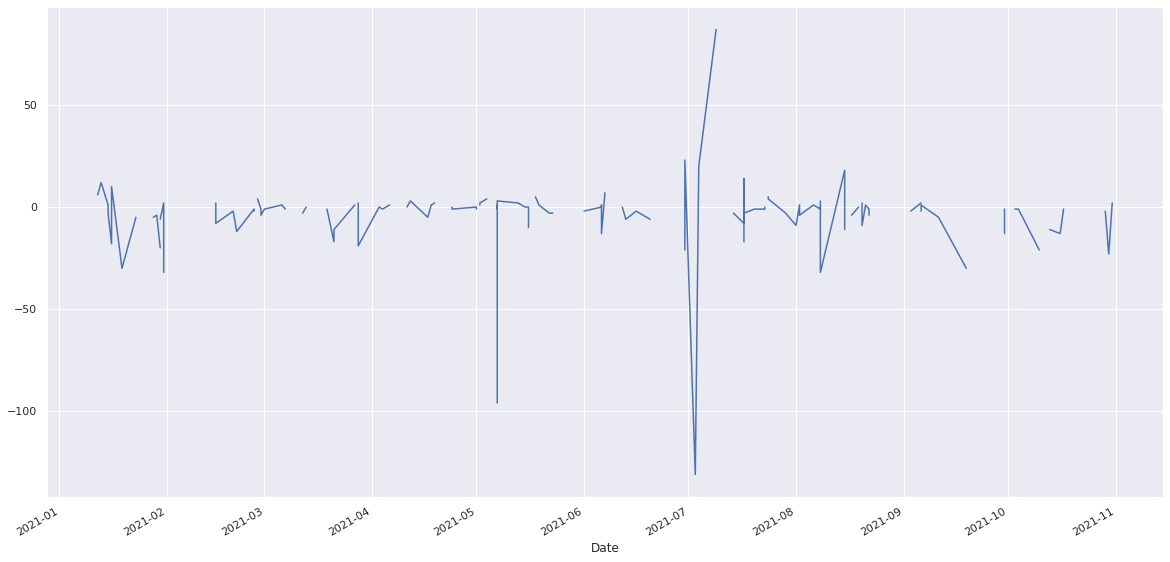

In [9]:
df.actual_range_minus_expected_range.plot()

Hm -- there are some outliers that I'll chase down later.  For now, let's try a scatter plot:  does `actual_range_minus_expected_range` change depending on the distance driven?

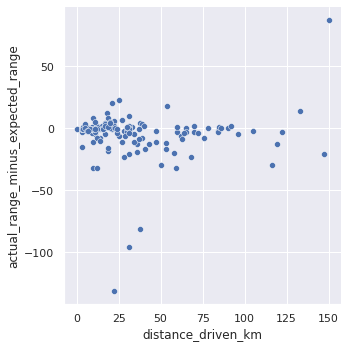

In [10]:
sns.relplot(y="actual_range_minus_expected_range", x="distance_driven_km", data=df)

Hm...some things to notice here:

- We drive a lot of short trips -- under 50km, say.
- Overall, it does look like the onboard estimates are a little optimistic -- but it's noticeably inaccurate in both directions around 25km.  That is, for real short trips (under 25km, say), the estimates are as (roughly) as likely to be optimistic as to be pessimistic.  (Note: need to come back and actually measure that!)
- At distances longer than ~ 50km, optimism seems to prevail: the car thinks it can go further with a given battery capacity than it does.

What about if we graph `actual_range_minus_expected_range` compared to battery charge?  Does accuracy change depending on charge?

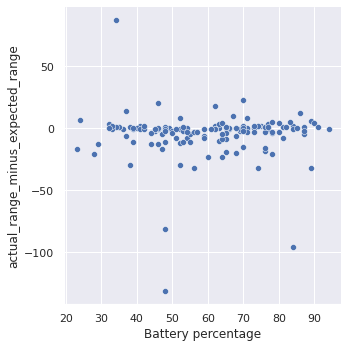

In [11]:
sns.relplot(y="actual_range_minus_expected_range", x="Battery percentage", data=df)

Nope, not really: it seems to be generally optimistic no matter what charge the battery is at.